In [131]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Pre Procesado

In [132]:
df = pd.read_csv( "/home/bautista/Datos/Machine-Learning-Datos/Training.csv" )
df

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,Q2,2016,NaT,10,EUR,5272800.00,EUR,5272800.0,Closed Lost,Prod_Category_A_None
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,Q1,2016,NaT,0,EUR,48230.00,EUR,48230.0,Closed Won,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,Q1,2016,NaT,0,USD,83865.60,USD,83865.6,Closed Won,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,14,USD,7421881.50,USD,7421881.5,Closed Lost,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,25,USD,13357192.50,USD,13357192.5,Closed Lost,Prod_Category_A_None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16942,8781,EMEA,Austria,1,1,1,1,0,Bureaucratic_Code_4,1/15/2016,...,Q1,2016,NaT,0,EUR,103350.00,EUR,299715.0,Closed Won,Prod_Category_A_None
16943,8786,EMEA,Austria,1,1,1,1,0,Bureaucratic_Code_4,1/15/2016,...,Q2,2016,NaT,0,EUR,93015.00,EUR,299715.0,Closed Won,Prod_Category_A_None
16944,8792,EMEA,Austria,1,1,1,1,0,Bureaucratic_Code_4,1/15/2016,...,Q1,2016,NaT,0,EUR,103350.00,EUR,299715.0,Closed Won,Prod_Category_A_None
16945,28561,Americas,NE America,1,1,1,1,0,Bureaucratic_Code_4,10/20/2015,...,Q2,2016,NaT,4,USD,2346796.88,USD,0.0,Closed Lost,Prod_Category_A_None


In [133]:
df.loc[df['Total_Amount_Currency'] == 'JPY', 'Total_Amount'] = df['Total_Amount']*0.0096
df.loc[df['Total_Amount_Currency'] == 'JPY', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'EUR', 'Total_Amount'] = df['Total_Amount']*1.17
df.loc[df['Total_Amount_Currency'] == 'EUR', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'AUD', 'Total_Amount'] = df['Total_Amount']*0.70
df.loc[df['Total_Amount_Currency'] == 'AUD', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'GBP', 'Total_Amount'] = df['Total_Amount']*1.29
df.loc[df['Total_Amount_Currency'] == 'GBP', 'Total_Amount_Currency'] = 'USD'

In [134]:
short_df = df[['Opportunity_ID','Region','Total_Amount','Delivery_Year', 'Delivery_Quarter','TRF','Pricing, Delivery_Terms_Approved','Pricing, Delivery_Terms_Quote_Appr','Stage' ]].rename(columns={'Stage': 'Decision'})
short_df = short_df[ (short_df['Decision'] == 'Closed Won') | (short_df['Decision'] == 'Closed Lost') ]
short_df['Decision'] = np.where(short_df['Decision'] == 'Closed Won',1,0)
short_df.set_index('Opportunity_ID', inplace = True)
short_df

,Region,Total_Amount,Delivery_Year,Delivery_Quarter,TRF,"Pricing, Delivery_Terms_Approved","Pricing, Delivery_Terms_Quote_Appr",Decision
Opportunity_ID,,,,,,,,
0,EMEA,6169176.00,2016,Q2,10,1,1,0
1,EMEA,56429.10,2016,Q1,0,0,0,1
2,Americas,83865.60,2016,Q1,0,0,0,1
3,Americas,7421881.50,2018,Q1,14,0,1,0
4,Americas,13357192.50,2018,Q1,25,0,1,0
...,...,...,...,...,...,...,...,...
12801,EMEA,120919.50,2016,Q1,0,1,1,1
12801,EMEA,108827.55,2016,Q2,0,1,1,1
12801,EMEA,120919.50,2016,Q1,0,1,1,1


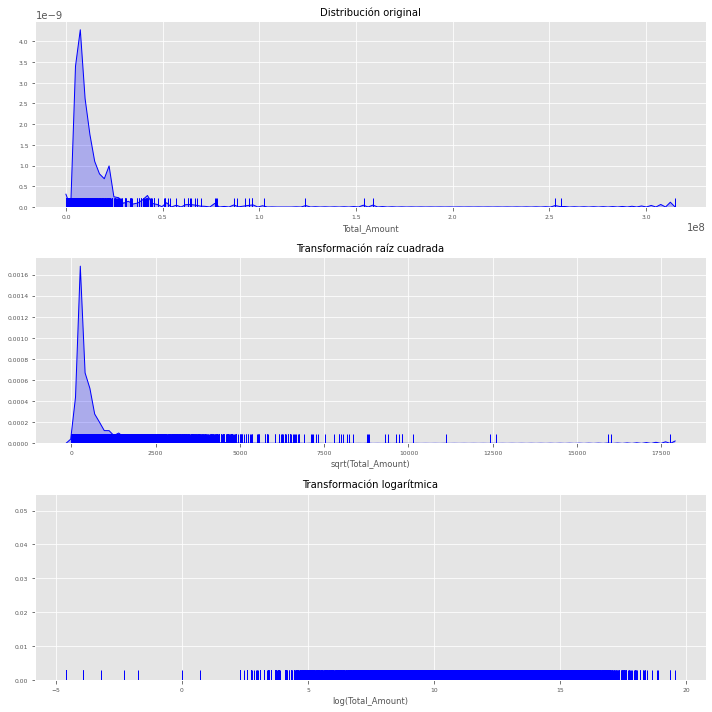

In [135]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
sns.distplot(
    short_df.Total_Amount,
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('Total_Amount', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.distplot(
    np.sqrt(short_df.Total_Amount),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(Total_Amount)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

sns.distplot(
    np.log(short_df.Total_Amount),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(Total_Amount)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

fig.tight_layout()

In [136]:
prueba = short_df
prueba.Total_Amount = np.log(prueba.Total_Amount)
prueba.shape

(16883, 8)

In [141]:
prueba = prueba[prueba['Total_Amount'] > 0]
prueba.describe()

,Total_Amount,Delivery_Year,TRF,"Pricing, Delivery_Terms_Approved","Pricing, Delivery_Terms_Quote_Appr",Decision
count,16758.000000,16758.000000,16758.000000,16758.000000,16758.000000,16758.000000
mean,10.481848,2017.134324,2.283566,0.585690,0.808032,0.568087
std,3.284313,0.820045,12.089545,0.492617,0.393860,0.495357
min,0.727549,2016.000000,0.000000,0.000000,0.000000,0.000000
25%,8.476371,2016.000000,0.000000,0.000000,1.000000,0.000000
50%,11.253377,2017.000000,0.000000,1.000000,1.000000,1.000000
75%,12.586112,2018.000000,1.000000,1.000000,1.000000,1.000000
max,19.568083,2019.000000,500.000000,1.000000,1.000000,1.000000


# Train y Test

In [138]:


# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        short_df.drop(columns = 'Decision'),
                                        short_df['Decision'],
                                        random_state = 123
                                    )

# One-hot-encoding de las variables categóricas
# ==============================================================================
# Se identifica el nobre de las columnas numéricas y categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

# Se aplica one-hot-encoding solo a las columnas categóricas
preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                    remainder='passthrough'
               )

# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

#El resultado devuelto por ColumnTransformer es un numpy array, por lo que se pierden los nombres de las columnas. Es interesante poder inspeccionar cómo queda el set de datos tras el preprocesado en formato dataframe. Por defecto, OneHotEncoder ordena las nuevas columnas de izquierda a derecha por orden alfabético.

# Convertir el output del ColumnTransformer en dataframe y añadir nombre columnas
# ==============================================================================
# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])

# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=labels)
X_test_prep  = pd.DataFrame(X_test_prep, columns=labels)
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12662 entries, 0 to 12661
Data columns (total 14 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Total_Amount                        12662 non-null  float64
 1   Delivery_Year                       12662 non-null  float64
 2   TRF                                 12662 non-null  float64
 3   Pricing, Delivery_Terms_Approved    12662 non-null  float64
 4   Pricing, Delivery_Terms_Quote_Appr  12662 non-null  float64
 5   Region_APAC                         12662 non-null  float64
 6   Region_Americas                     12662 non-null  float64
 7   Region_EMEA                         12662 non-null  float64
 8   Region_Japan                        12662 non-null  float64
 9   Region_Middle East                  12619 non-null  float64
 10  Delivery_Quarter_Q1                 12662 non-null  float64
 11  Delivery_Quarter_Q2                 12662

# Encoding

In [139]:


# Convertir el output del ColumnTransformer en dataframe y añadir nombre columnas
# ==============================================================================
# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])

# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=labels)
X_test_prep  = pd.DataFrame(X_test_prep, columns=labels)
X_train_prep.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12662 entries, 0 to 12661
Data columns (total 14 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Total_Amount                        12662 non-null  float64
 1   Delivery_Year                       12662 non-null  float64
 2   TRF                                 12662 non-null  float64
 3   Pricing, Delivery_Terms_Approved    12662 non-null  float64
 4   Pricing, Delivery_Terms_Quote_Appr  12662 non-null  float64
 5   Region_APAC                         12662 non-null  float64
 6   Region_Americas                     12662 non-null  float64
 7   Region_EMEA                         12662 non-null  float64
 8   Region_Japan                        12662 non-null  float64
 9   Region_Middle East                  12619 non-null  float64
 10  Delivery_Quarter_Q1                 12662 non-null  float64
 11  Delivery_Quarter_Q2                 12662

# Grid Serch de Hiperparametros

In [140]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train_prep, y_train)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(4)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
# VERSIÓN PARALELIZADA
# ==============================================================================

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop paralelizado para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
def eval_oob_error(X, y, modelo, params, verbose=True):
    """
    Función para entrenar un modelo utilizando unos parámetros determinados
    y que devuelve el out-of-bag error
    """
    modelo.set_params(
        oob_score    = True,
        n_jobs       = -1,
        random_state = 123,
        ** params            
    )
    
    modelo.fit(X, y)
    
    if verbose:
        print(f"Modelo: {params} \u2713")
        
    return{'params': params, 'oob_accuracy': modelo.oob_score_}


n_jobs     = multiprocessing.cpu_count() -1
pool       = multiprocessing.Pool(processes=n_jobs)
resultados = pool.starmap(
                eval_oob_error,
                [(X_train_prep, y_train, RandomForestClassifier(), params) for params in param_grid]
             )

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados.head(4)

In [ ]:
# Mejores hiperparámetros por out-of-bag error
# ==============================================================================
print("--------------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-accuracy)")
print("--------------------------------------------------")
print(resultados.iloc[0,0], ":", resultados.iloc[0,:]['oob_accuracy'], "accuracy")

In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [150],
              'max_features': [5, 7, 9],
              'max_depth'   : [None, 3, 10, 20],
              'criterion'   : ['gini', 'entropy']
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_prep, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)



In [ ]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

# Prediccion

In [ ]:
modelo_final = grid.best_estimator_

In [ ]:
# Error de test del modelo final
# ==============================================================================
predicciones = modelo_final.predict(X = X_test_prep)
predicciones[:10]

In [ ]:
mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

In [ ]:


print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)



In [ ]:
DataFrame_test = pd.read_csv( "/home/bautista/Datos/Machine-Learning-Datos/Test/Test.csv" )
DataFrame_test

In [ ]:
DataFrame_test.loc[df['Total_Amount_Currency'] == 'JPY', 'Total_Amount'] = DataFrame_test['Total_Amount']*0.0096
DataFrame_test.loc[df['Total_Amount_Currency'] == 'JPY', 'Total_Amount_Currency'] = 'USD'

DataFrame_test.loc[df['Total_Amount_Currency'] == 'EUR', 'Total_Amount'] = DataFrame_test['Total_Amount']*1.17
DataFrame_test.loc[df['Total_Amount_Currency'] == 'EUR', 'Total_Amount_Currency'] = 'USD'

DataFrame_test.loc[df['Total_Amount_Currency'] == 'AUD', 'Total_Amount'] = DataFrame_test['Total_Amount']*0.70
DataFrame_test.loc[df['Total_Amount_Currency'] == 'AUD', 'Total_Amount_Currency'] = 'USD'

DataFrame_test.loc[df['Total_Amount_Currency'] == 'GBP', 'Total_Amount'] = DataFrame_test['Total_Amount']*1.29
DataFrame_test.loc[df['Total_Amount_Currency'] == 'GBP', 'Total_Amount_Currency'] = 'USD'

In [ ]:
DataFrame_test = DataFrame_test[['Opportunity_ID','Region','Total_Amount', 'Delivery_Year', 'Delivery_Quarter','TRF','Pricing, Delivery_Terms_Approved','Pricing, Delivery_Terms_Quote_Appr' ]]
DataFrame_test = DataFrame_test.drop_duplicates('Opportunity_ID',keep = 'last')
DataFrame_test.set_index('Opportunity_ID', inplace = True)
DataFrame_test

# Encoding

In [ ]:
# One-hot-encoding de las variables categóricas
# ==============================================================================
# Se identifica el nobre de las columnas numéricas y categóricas
cat_cols = DataFrame_test.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = DataFrame_test.select_dtypes(include=['float64', 'int']).columns.to_list()

# Se aplica one-hot-encoding solo a las columnas categóricas
preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                    remainder='passthrough'
               )

# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
DataFrame_test_prep = preprocessor.fit_transform(DataFrame_test)

#El resultado devuelto por ColumnTransformer es un numpy array, por lo que se pierden los nombres de las columnas. Es interesante poder inspeccionar cómo queda el set de datos tras el preprocesado en formato dataframe. Por defecto, OneHotEncoder ordena las nuevas columnas de izquierda a derecha por orden alfabético.

# Convertir el output del ColumnTransformer en dataframe y añadir nombre columnas
# ==============================================================================
# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])

# Conversión a dataframe
DataFrame_test = pd.DataFrame(DataFrame_test, columns=labels)
DataFrame_test.info()

In [ ]:
DataFrame_test_prep = pd.DataFrame(DataFrame_test_prep, columns=labels)
DataFrame_test_prep.info()

In [ ]:
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])

# Conversión a dataframe
DataFrame_test_prep  = pd.DataFrame(DataFrame_test_prep, columns=labels)
DataFrame_test_prep.info()

# Prediction

In [ ]:
pred_posta = modelo_final.predict(X = DataFrame_test_prep)

In [ ]:
prueba = DataFrame_test.reset_index()['Opportunity_ID']
prueba

In [ ]:
subir = pd.DataFrame()
subir['Opportunity_ID'] = DataFrame_test.reset_index()['Opportunity_ID']
subir['target'] = pred_posta
#subir.sort_values('Opportunity_ID',inplace = True)
subir = subir.drop_duplicates('Opportunity_ID',keep = 'last')
subir.set_index('Opportunity_ID', inplace = True)
subir

In [ ]:
subir['target'].value_counts()

In [ ]:
subir.to_csv('RandomForest.csv')